In [1]:
import polars as pl
import numpy as np
import pandas as pd
from sklearn.decomposition import FactorAnalysis
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from matplotlib import pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from collections import Counter
import os
import warnings
import seaborn as sns

diretorio = "D:\dados - tcc mba/csv_files"
warnings.filterwarnings("ignore")


# Tratamento dos dados
- set_table_dtypes = Dados de colunas que terminam em 'P' ou 'A' são transformados em float64;
- convert_strings = Converte colunas de strings em um DataFrame pandas em colunas categóricas
- filter_data = retira a coluna de acordo o numero de NaNs e deleta coluna de acordo o número de valores únicos;


In [140]:
def set_table_dtypes(df: pl.DataFrame) -> pl.DataFrame:
    for col in df.columns:
        # last letter of column name will help you determine the type
        if col[-1] in ("P", "A"):
            df = df.with_columns(pl.col(col).cast(pl.Float64).alias(col))

    return df

def convert_strings(df: pd.DataFrame) -> pd.DataFrame:
    for col in df.columns:  
        if df[col].dtype.name in ['object', 'string']:
            df[col] = df[col].astype("string").astype('category')
            current_categories = df[col].cat.categories
            new_categories = current_categories.to_list() + ["Unknown"]
            new_dtype = pd.CategoricalDtype(categories=new_categories, ordered=True)
            df[col] = df[col].astype(new_dtype)
    return df

def filter_cols(df):
    # Retira colunas que tenham mais de 80% de valores nulos
    colunas_fixas = ["target", "case_id", "WEEK_NUM", 'totalamount_6A',
                    'totalamount_996A', 'totaldebtoverduevalue_178A', 'totaldebtoverduevalue_718A',
                    'totaloutstanddebtvalue_39A', 'totaloutstanddebtvalue_668A']
    cols_to_drop = []
    for col in df.columns:
        if col not in colunas_fixas:
            isnull = df[col].isnull().mean()
            if isnull > 0.7:
                cols_to_drop.append(col)

    df = df.drop(columns=cols_to_drop, errors='ignore')

    # Vê a quantidade de valores únicos na coluna, se a coluna tiver exatamente um valor único ou mais de 200, essa coluna é excluída
    cols_to_drop = []
    for col in df.columns:
        if col not in colunas_fixas:
            unique_count = df[col].nunique()
            if unique_count == 1 or unique_count > 200:
                cols_to_drop.append(col)

    df = df.drop(columns=cols_to_drop, errors='ignore')

    return df

def filter_nans(df, limite):
    # Calcular a proporção de valores NaN em cada coluna
    proporcao_nans = df.isna().mean()

    # Selecionar colunas que têm proporção de NaN menor ou igual ao limite
    colunas_para_manter = proporcao_nans[proporcao_nans <= limite].index

    # Filtrar o DataFrame para manter apenas as colunas selecionadas
    df_filtrado = df[colunas_para_manter]

    return df_filtrado

def filter_unique(df):
    # Contagem de valores únicos em cada coluna
    unique_counts = df.nunique()

    # Selecionar colunas que têm número de valores únicos entre 2 e 200 (inclusive)
    colunas_para_manter = unique_counts[(unique_counts > 1) & (unique_counts <= 100)].index

    # Filtrar o DataFrame para manter apenas as colunas selecionadas
    df_filtrado = df[list(colunas_para_manter)]

    return df_filtrado 

def filter_data(df, limite_nans):
    """
    Filtra o DataFrame para manter apenas as colunas que atendem aos critérios específicos:
    - Para colunas numéricas (float64 e int64): remove colunas com proporção de NaN menor ou igual ao limite.
    - Para colunas categóricas (object e category): mantém colunas com número de valores únicos entre 1 e 100.

    Parâmetros:
    df (DataFrame): DataFrame pandas de entrada.
    limite_nans (float): Limite percentual de NaNs permitido para colunas numéricas (por padrão, 0.15 para 15%).

    Retorno:
    DataFrame: DataFrame com colunas filtradas.
    """
    colunas_para_manter = []

    for coluna in df.columns:
        if df[coluna].dtype in ['float64', 'int64']:
            # Verifica a proporção de NaNs na coluna
            proporcao_nans = df[coluna].isna().mean()
            if proporcao_nans > limite_nans:
                colunas_para_manter.append(coluna)
        elif df[coluna].dtype in ['object', 'category']:
            # Verifica o número de valores únicos na coluna
            num_valores_unicos = df[coluna].nunique()
            if 1 <= num_valores_unicos <= 10:
                colunas_para_manter.append(coluna)

    # Filtra o DataFrame para manter apenas as colunas selecionadas
    df_filtrado = df[colunas_para_manter]

    return df_filtrado


# Importação de dados do diretório
Precisa-se de um método e explicações para selecionar determinadas bases, visto que tenho recurso computacional limitado.

In [152]:
# ---------- Dados Treino

train_basetable = pl.read_csv(diretorio + "/train/train_base.csv")
train_static = pl.concat(
    [
        pl.read_csv(diretorio + "/train/train_static_0_0.csv").pipe(set_table_dtypes),
        pl.read_csv(diretorio + "/train/train_static_0_1.csv").pipe(set_table_dtypes),
    ],
    how="vertical_relaxed",
)
train_static_cb = pl.read_csv(diretorio + "/train/train_static_cb_0.csv").pipe(set_table_dtypes)
train_person_1 = pl.read_csv(diretorio + "/train/train_person_1.csv").pipe(set_table_dtypes) 
train_credit_bureau_b_2 = pl.read_csv(diretorio + "/train/train_credit_bureau_b_2.csv").pipe(set_table_dtypes)

In [153]:
# ---------- Dados Teste

test_basetable = pl.read_csv(diretorio + "/test/test_base.csv")
test_static = pl.concat(
    [
        pl.read_csv(diretorio + "/test/test_static_0_0.csv").pipe(set_table_dtypes),
        pl.read_csv(diretorio + "/test/test_static_0_1.csv").pipe(set_table_dtypes),
        pl.read_csv(diretorio + "/test/test_static_0_2.csv").pipe(set_table_dtypes),
    ],
    how="vertical_relaxed",
)
test_static_cb = pl.read_csv(diretorio + "/test/test_static_cb_0.csv").pipe(set_table_dtypes)
test_person_1 = pl.read_csv(diretorio + "/test/test_person_1.csv").pipe(set_table_dtypes) 
test_credit_bureau_b_2 = pl.read_csv(diretorio + "/test/test_credit_bureau_b_2.csv").pipe(set_table_dtypes) 

# Agrupamento e organização dos dados
O depth vai de 0 a 2, sendo que zero é o conjunto de dados menos agrupados (mais granulares) e dois são os dados mais agrupados (menos granulares)


In [176]:
train_person_1_feats_1 = train_person_1.group_by("case_id").agg(
    pl.col("mainoccupationinc_384A").max().alias("mainoccupationinc_384A_max"),
    (pl.col("incometype_1044T") == "SELFEMPLOYED").max().alias("mainoccupationinc_384A_any_selfemployed"))


# Pessoa que solicitou o empréstimo
train_person_1_feats_2 = train_person_1.select(["case_id", "num_group1", "housetype_905L",'gender_992L','maritalst_703L']).filter(
    pl.col("num_group1") == 0
).drop("num_group1").rename({"housetype_905L": "person_housetype"})

# Agrupamento
train_credit_bureau_b_2_feats = train_credit_bureau_b_2.group_by("case_id").agg(
    pl.col("pmts_pmtsoverdue_635A").max().alias("pmts_pmtsoverdue_635A_max"),
    (pl.col("pmts_dpdvalue_108P") > 31).max().alias("pmts_dpdvalue_108P_over31")
)

selected_static_cols = []
for col in train_static.columns:
    if col[-1] in ('A', 'M'):
        selected_static_cols.append(col)


selected_static_cb_cols = []
for col in train_static_cb.columns:
    if col[-1] in ('A', 'M'):
        selected_static_cb_cols.append(col)


# Join
data_treino = train_basetable.join(
    train_static.select(["case_id"]+selected_static_cols), how="left", on="case_id"
).join(
    train_static_cb.select(["case_id"]+selected_static_cb_cols), how="left", on="case_id"
).join(
    train_person_1_feats_1, how="left", on="case_id"
).join(
    train_person_1_feats_2, how="left", on="case_id"
).join(
    train_credit_bureau_b_2_feats, how="left", on="case_id"
)

In [177]:
test_person_1_feats_1 = test_person_1.group_by("case_id").agg(
    pl.col("mainoccupationinc_384A").max().alias("mainoccupationinc_384A_max"),
    (pl.col("incometype_1044T") == "SELFEMPLOYED").max().alias("mainoccupationinc_384A_any_selfemployed")
)

test_person_1_feats_2 = test_person_1.select(["case_id", "num_group1", "housetype_905L",'gender_992L','maritalst_703L']).filter(
    pl.col("num_group1") == 0
).drop("num_group1").rename({"housetype_905L": "person_housetype"})

test_credit_bureau_b_2_feats = test_credit_bureau_b_2.group_by("case_id").agg(
    pl.col("pmts_pmtsoverdue_635A").max().alias("pmts_pmtsoverdue_635A_max"),
    (pl.col("pmts_dpdvalue_108P") > 31).max().alias("pmts_dpdvalue_108P_over31")
)

data_teste = test_basetable.join(
    test_static.select(["case_id"]+selected_static_cols), how="left", on="case_id"
).join(
    test_static_cb.select(["case_id"]+selected_static_cb_cols), how="left", on="case_id"
).join(
    test_person_1_feats_1, how="left", on="case_id"
).join(
    test_person_1_feats_2, how="left", on="case_id"
).join(
    test_credit_bureau_b_2_feats, how="left", on="case_id"

)



# Tratamento dos IDs, seleção de colunas, conversão polars para pandas

In [178]:
# Embaralha os IDs de casos únicos no conjunto de dados data_treino e divide esses IDs em treino, teste e validação
# Embaralha os IDs de casos únicos no conjunto de dados data_treino e divide esses IDs em treino, teste e validação
case_ids = data_treino["case_id"].unique().shuffle(seed=1)
case_ids_train, case_ids_test = train_test_split(case_ids, train_size=0.7, random_state=1)
case_ids_valid, case_ids_test = train_test_split(case_ids_test, train_size=0.7, random_state=1)

# Adiciona à lista cols_pred todas as colunas cujo último caractere é uma letra maiúscula e os caracteres anteriores são letras minúsculas.
cols_pred = []
for col in data_treino.columns:
    if col[-1].isupper() and col[:-1].islower():
        cols_pred.append(col)

# Polars para Pandas
def from_polars_to_pandas(case_ids: pl.Series) -> tuple:
    filtered_data = data_treino.filter(pl.col("case_id").is_in(case_ids))
    base = filtered_data[["case_id", "WEEK_NUM", "target"]].to_pandas()
    x = filtered_data[cols_pred].to_pandas()
    y = filtered_data["target"].to_pandas()
    return base, x, y

base_train, treino_x, treino_y = from_polars_to_pandas(case_ids_train)
base_valid, valid_x, valid_y = from_polars_to_pandas(case_ids_valid)
base_test, teste_x, teste_y = from_polars_to_pandas(case_ids_test)

# Verificar e garantir que todas as colunas existam em todos os conjuntos de dados
all_columns = set(treino_x.columns).union(set(valid_x.columns)).union(set(teste_x.columns))

for df in [treino_x, valid_x, teste_x]:
    for col in all_columns:
        if col not in df.columns:
            df[col] = pd.NA

# Polars para Pandas
def convert_strings(df: pd.DataFrame) -> pd.DataFrame:
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].astype(str)
    return df

# Converte colunas de strings se necessário
for df in [treino_x, valid_x, teste_x]:
    df = convert_strings(df)

In [179]:
print(f"Treino: {treino_x.shape}")
print(f"Validação: {valid_x.shape}")
print(f"Teste: {teste_x.shape}")

Treino: (1068661, 50)
Validação: (320598, 50)
Teste: (137400, 50)


# Retira colunas que tenham mais de 30% de valores nulos e retira variáveis com muito valores repetidos

In [180]:
limite = 0.30

treino_x = filter_data(treino_x, limite)
valid_x = filter_data(valid_x, limite)
teste_x = filter_data(teste_x, limite)

# -------- Retirar colunas: 
# education_1103M
# maritalst_893M
# pmtaverage_4527227A
# pmtaverage_4955615A

# treino_x = treino_x.drop(['education_1103M','maritalst_893M','pmtaverage_4527227A','pmtaverage_4955615A'], axis=1)
# valid_x = valid_x.drop(['education_1103M','maritalst_893M','pmtaverage_4527227A','pmtaverage_4955615A'], axis=1)
# teste_x = teste_x.drop(['education_1103M','maritalst_893M','pmtaverage_4527227A','pmtaverage_4955615A'], axis=1)


print(f"Treino: {treino_x.shape}")
print(f"Validação: {valid_x.shape}")
print(f"Teste: {teste_x.shape}")



Treino: (1068661, 28)
Validação: (320598, 28)
Teste: (137400, 28)


# Análise descritiva das features quantitativas da base treino


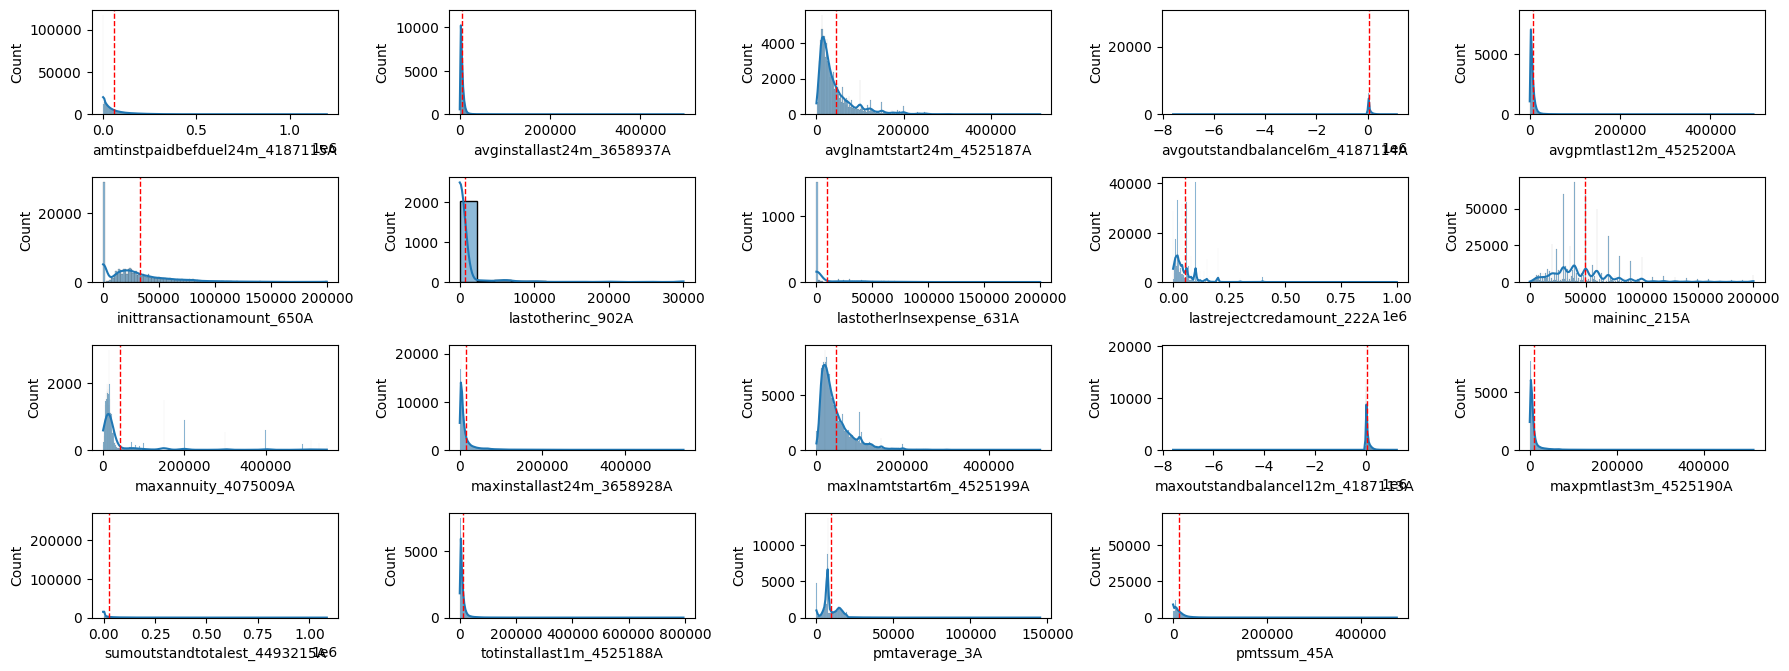

In [159]:
var_quant = treino_x.select_dtypes(exclude=['object', 'category'])

# Calcular a média das variáveis quantitativas
mean_var_quant = var_quant.mean().round(2)

# Configuração para melhor visualização dos gráficos
plt.figure(figsize=(18, 50))

# Plotar histogramas para cada variável quantitativa baseado na média
for i, col in enumerate(var_quant.columns):
    plt.subplot(30, 5, i + 1)
    sns.histplot(var_quant[col], kde=True)
    plt.axvline(mean_var_quant[col], color='red', linestyle='dashed', linewidth=1)  # linha para média

plt.tight_layout()
plt.show()

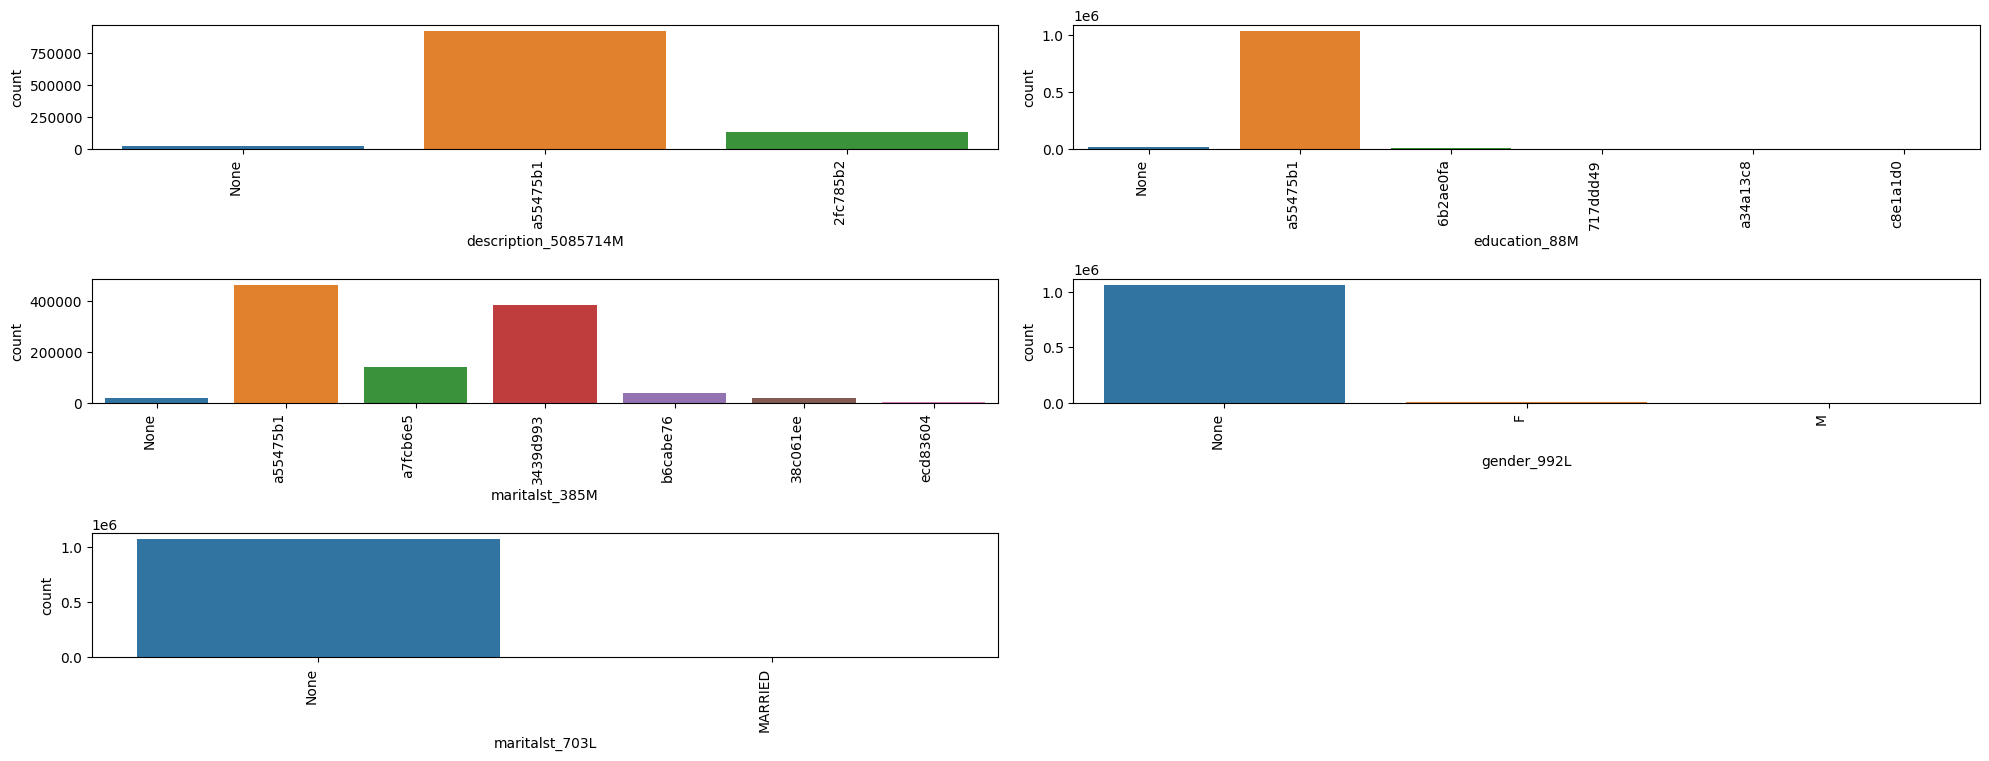

In [160]:
var_quali = treino_x.select_dtypes(include=['object', 'category'])

# Criar DataFrame
var_quali = pd.DataFrame(var_quali)

# Configuração para visualização dos gráficos
plt.figure(figsize=(20, 50))

# Plotar gráficos de contagem para cada variável qualitativa
for i, col in enumerate(var_quali.columns):
    plt.subplot(20, 2, i + 1)  # Ajuste para uma grade de 3 linhas por 2 colunas
    sns.countplot(x=col, data=var_quali)
    plt.xticks(rotation=90, ha='right')  # Rotacionar os rótulos do eixo x para melhorar a leitura

plt.tight_layout()
plt.show()


# Preenchendo valores NaN com a média

In [181]:
# Selecionar colunas numéricas
colunas_numericas_treino = treino_x.select_dtypes(include=['float64', 'int64']).columns
colunas_numericas_valid = valid_x.select_dtypes(include=['float64', 'int64']).columns
colunas_numericas_teste = teste_x.select_dtypes(include=['float64', 'int64']).columns

# Imputação de valores ausentes usando SimpleImputer
imputador = SimpleImputer(strategy='mean')

# Para a base de treino
treino_x[colunas_numericas_treino] = imputador.fit_transform(treino_x[colunas_numericas_treino])

# Para a base de validação
valid_x[colunas_numericas_valid] = imputador.transform(valid_x[colunas_numericas_valid])

# Para a base de teste
teste_x[colunas_numericas_teste] = imputador.transform(teste_x[colunas_numericas_teste])

# Balanceamento dos dados quantitativos

In [ ]:
# colunas_numericas = treino_x.select_dtypes(include = ['float64','int64']).columns
# colunas_categoricas = treino_x.select_dtypes(include = ['object','category']).columns

# treino_x_num = treino_x[colunas_numericas]
# treino_x_cat = treino_x[colunas_categoricas]

# smote = SMOTE(random_state=42)
# treino_x, treino_y = smote.fit_resample(treino_x, treino_y)

# # Juntando os dados pós balanceamento
# treino_x = pd.concat([pd.DataFrame(treino_x, columns=colunas_numericas), treino_x_cat.reset_index(drop=True)], axis=1)


# Análise fatorial para diminuir dimensionalidade das variáveis


In [182]:
var_numericas = treino_x.select_dtypes(include=['float64', 'int64']).columns
var_categoricas = treino_x.select_dtypes(include=['object', 'category']).columns

# Pipeline para pré-processamento de variáveis
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())  # Normalização ou padronização dos dados numéricos, se necessário
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, var_numericas),
        ('cat', OneHotEncoder(handle_unknown='ignore'), var_categoricas)
    ])

# Aplicar pré-processamento e ajustar a matriz de treino
treino_x_preprocessed = preprocessor.fit_transform(treino_x)
treino_x_preprocessed_df = pd.DataFrame(treino_x_preprocessed, index=treino_x.index, columns=var_numericas.tolist() + preprocessor.named_transformers_['cat'].get_feature_names_out(var_categoricas).tolist())

# Aplicar o mesmo pré-processamento nos conjuntos de validação e teste
valid_x_preprocessed = preprocessor.transform(valid_x)
teste_x_preprocessed = preprocessor.transform(teste_x)

# Combinar fatores (se aplicável) com as colunas originais
# Análise Fatorial
n_factors = 5
fa = FactorAnalysis(n_components=n_factors, random_state=42)

# Ajustar e transformar os dados de treino
treino_x_factors = fa.fit_transform(treino_x_preprocessed_df)

# Transformar os dados de validação e teste
valid_x_factors = fa.transform(valid_x_preprocessed)
teste_x_factors = fa.transform(teste_x_preprocessed)

# Converter de volta para DataFrames
treino_x_factors_df = pd.DataFrame(treino_x_factors, index=treino_x.index, columns=[f'Factor{i+1}' for i in range(n_factors)])
valid_x_factors_df = pd.DataFrame(valid_x_factors, index=valid_x.index, columns=[f'Factor{i+1}' for i in range(n_factors)])
teste_x_factors_df = pd.DataFrame(teste_x_factors, index=teste_x.index, columns=[f'Factor{i+1}' for i in range(n_factors)])

# Combinar fatores com as colunas numéricas originais
treino_x_combined = treino_x.drop(columns=var_categoricas).join(treino_x_factors_df)
valid_x_combined = valid_x.drop(columns=var_categoricas).join(valid_x_factors_df)
teste_x_combined = teste_x.drop(columns=var_categoricas).join(teste_x_factors_df)

<Figure size 1000x600 with 0 Axes>

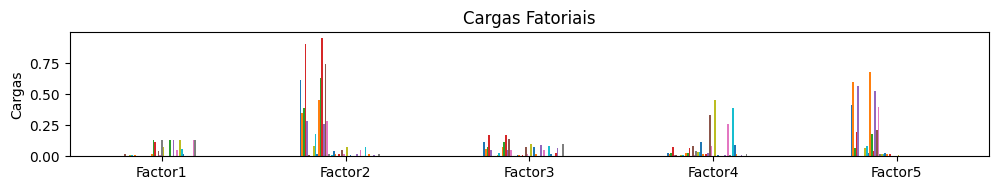

In [183]:
# Calcular as cargas fatoriais
cargas_fatoriais = fa.components_
cargas_fatoriais_df = pd.DataFrame(cargas_fatoriais, columns=treino_x_preprocessed_df.columns, index=[f'Factor{i+1}' for i in range(n_factors)])

# Plotar as cargas fatoriais
plt.figure(figsize=(10, 6))
cargas_fatoriais_df.abs().plot(kind='bar', figsize=(10, 2), legend=False)
plt.title('Cargas Fatoriais')
plt.ylabel('Cargas')
plt.xticks(rotation=0)
# plt.legend(loc='upper right')
plt.tight_layout()
plt.show()



# Top 10 Variáveis:

In [164]:
# Identificar as 10 variáveis com maior carga fatorial por fator
top_var = {}
for factor in cargas_fatoriais_df.index:
    sorted_vars = cargas_fatoriais_df.loc[factor].abs().sort_values(ascending=False)
    top_variables = sorted_vars.index[:10]  # Seleciona as top 10 variáveis com maior carga fatorial
    top_var[factor] = top_variables.tolist()

# Criar tabela formatada
df_var = pd.DataFrame.from_dict(top_var, orient='index').transpose()

# Adicionar uma linha de descrição
df_var = pd.concat([pd.DataFrame([['-']* n_factors], columns=df_var.columns), df_var], ignore_index=True)
df_var

,Factor1,Factor2,Factor3,Factor4,Factor5
0,-,-,-,-,-
1,description_5085714M_a55475b1,description_5085714M_None,gender_992L_None,maxoutstandbalancel12m_4187113A,maxinstallast24m_3658928A
2,description_5085714M_2fc785b2,maritalst_385M_None,gender_992L_F,avgoutstandbalancel6m_4187114A,avginstallast24m_3658937A
3,amtinstpaidbefduel24m_4187115A,education_88M_None,maininc_215A,sumoutstandtotalest_4493215A,avgpmtlast12m_4525200A
4,maritalst_385M_a55475b1,education_88M_a55475b1,amtinstpaidbefduel24m_4187115A,maxlnamtstart6m_4525199A,maxpmtlast3m_4525190A
5,maxinstallast24m_3658928A,description_5085714M_2fc785b2,sumoutstandtotalest_4493215A,amtinstpaidbefduel24m_4187115A,amtinstpaidbefduel24m_4187115A
6,lastrejectcredamount_222A,maritalst_385M_3439d993,lastrejectcredamount_222A,maxinstallast24m_3658928A,totinstallast1m_4525188A
7,maxlnamtstart6m_4525199A,maritalst_385M_a55475b1,maxoutstandbalancel12m_4187113A,avglnamtstart24m_4525187A,sumoutstandtotalest_4493215A
8,avginstallast24m_3658937A,description_5085714M_a55475b1,gender_992L_M,avginstallast24m_3658937A,avgoutstandbalancel6m_4187114A
9,maxoutstandbalancel12m_4187113A,inittransactionamount_650A,avgoutstandbalancel6m_4187114A,avgpmtlast12m_4525200A,maxlnamtstart6m_4525199A


# Random Forest

In [111]:
# Definir o modelo RandomForestClassifier
rf = RandomForestClassifier(random_state=123)

# Treinar o modelo usando os dados de treino combinados
rf.fit(treino_x_combined, treino_y)

RandomForestClassifier(random_state=123)

# Hiperparâmetros *default*

In [115]:
parametros = rf.get_params()
parametros = pd.DataFrame(parametros.items(), columns=['Hiperparâemtros', 'Valor'])
print(parametros)
parametros.to_excel('parametros.xlsx')

             Hiperparâemtros  Valor
0                  bootstrap   True
1                  ccp_alpha    0.0
2               class_weight   None
3                  criterion   gini
4                  max_depth   None
5               max_features   sqrt
6             max_leaf_nodes   None
7                max_samples   None
8      min_impurity_decrease    0.0
9           min_samples_leaf      1
10         min_samples_split      2
11  min_weight_fraction_leaf    0.0
12              n_estimators    100
13                    n_jobs   None
14                 oob_score  False
15              random_state    123
16                   verbose      0
17                warm_start  False


# Avaliação do modelo - Resultados

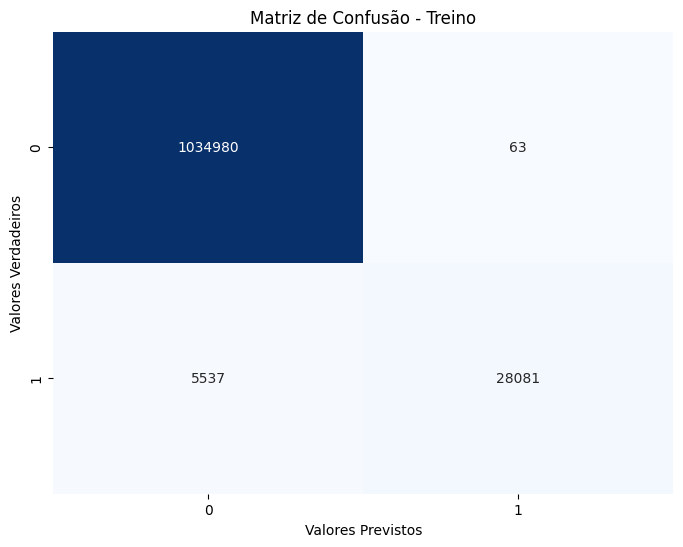

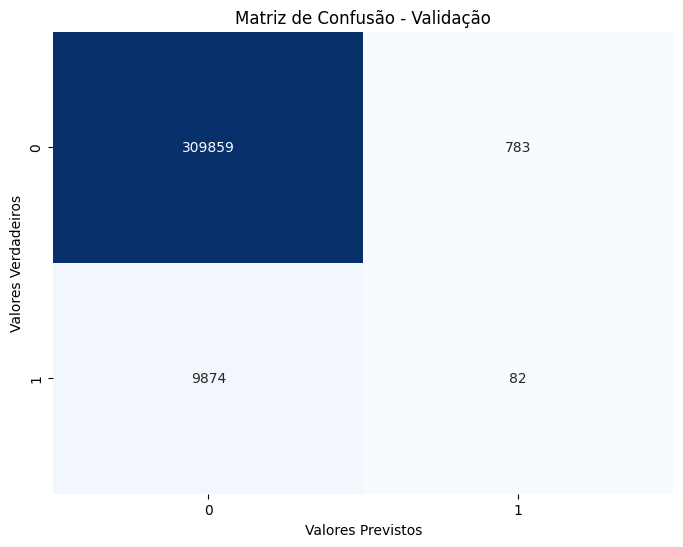

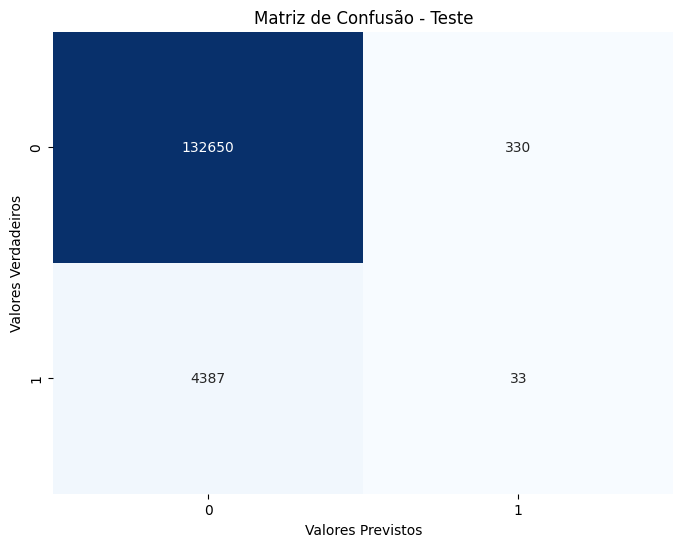

In [113]:

resultados = []

# Avaliar o modelo nos conjuntos de treino, validação e teste
for i, x, y in zip(['Treino', 'Validação', 'Teste'],
                    [treino_x_combined, valid_x_combined, teste_x_combined],
                    [treino_y, valid_y, teste_y]):
    # Prever os valores
    y_pred = rf.predict(x)

    # Calcular a matriz de confusão
    matriz_confusao = confusion_matrix(y, y_pred)

    # # Calcular o F1-score
    # f1 = f1_score(y, y_pred)

    # Calcular o ROC-AUC score
    y_proba = rf.predict_proba(x)[:, 1]
    roc_auc = roc_auc_score(y, y_proba)

    # Calcular a acurácia
    acuracia = accuracy_score(y, y_pred)
    
    # Guardar os resultados em uma lista
    resultados.append([i,  roc_auc, acuracia])

    # Plotar a matriz de confusão
    plt.figure(figsize=(8, 6))
    sns.heatmap(matriz_confusao, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Matriz de Confusão - {i}')
    plt.xlabel('Valores Previstos')
    plt.ylabel('Valores Verdadeiros')
    plt.show()

    # Exibir o F1-score, ROC-AUC score e acurácia
    # print(f'{i}:')
    # print(f'F1-score: {f1:.4f}')
    # print(f'ROC-AUC score: {roc_auc:.4f}')
    # print(f'Acurácia: {acuracia:.4f}')


In [114]:
# Criar DataFrame com os resultados
resultados_df = pd.DataFrame(resultados, columns=['Conjunto', 'ROC-AUC score', 'Acurácia']).round(4)
resultados_df

,Conjunto,ROC-AUC score,Acurácia
0,Treino,0.9850,0.9948
1,Validação,0.6291,0.9668
2,Teste,0.6378,0.9657


---------------------------------------------------

# Interpretação do F1-Score:
- Valor Próximo a 1: Indica que o modelo tem alta precisão e alta revocação, ou seja, ele prevê corretamente a maioria dos positivos e tem poucos falsos positivos e falsos negativos;
- Valor Próximo a 0: Indica que o modelo tem baixa precisão e baixa revocação, ou seja, ele prevê muitos falsos positivos e/ou muitos falsos negativos;
- Equilíbrio: O F1-score é equilibrado apenas se tanto a precisão quanto a revocação são equilibradas. Um modelo pode ter um F1-score alto mesmo se um dos componentes for baixo, desde que o outro seja alto o suficiente para compensar;

# 1 = inadimplentes
# 0 = adimplentes